<div> 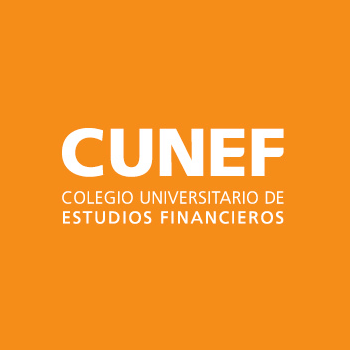
</div>


# **Hipotecas en España**
En este notebook se mostrará la serie temporal del **número de hipotecas en España** y observaremos cómo afectó ésta frente al COVID-19. 



Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV del número de hipotecas del TOTAL DE FINCAS en España.

- Fuente: https://datos.gob.es/es/catalogo/ea0010587-hipotecas-constituidas-sobre-el-total-de-fincas-por-naturaleza-de-la-finca-mensual-comunidades-autonomas-estadistica-de-hipotecas-identificador-api-138961

In [52]:
df_hipotecas = pd.read_csv("hipotecas2.csv", sep = ";", on_bad_lines='skip')
df_hipotecas

,Comunidades Autonomas,Naturaleza de la finca,Número e importe,Periodo,Total
0,Total Nacional,Total fincas,Número de hipotecas,2022M05,57.463
1,Total Nacional,Total fincas,Número de hipotecas,2022M04,44.230
2,Total Nacional,Total fincas,Número de hipotecas,2022M03,57.760
3,Total Nacional,Total fincas,Número de hipotecas,2022M02,49.147
4,Total Nacional,Total fincas,Número de hipotecas,2022M01,46.946
...,...,...,...,...,...
55915,"17 Rioja, La",Otros,Importe de hipotecas,2003M05,25.726
55916,"17 Rioja, La",Otros,Importe de hipotecas,2003M04,14.410
55917,"17 Rioja, La",Otros,Importe de hipotecas,2003M03,14.926
55918,"17 Rioja, La",Otros,Importe de hipotecas,2003M02,8.950


Observamos que el DataFrame que nos lee Jupyter Notebook tiene varios valores en las filas en cada variable, vamos a mirar qué contiene en las variables "Comunidades Autónomas" y "Naturaleza de la finca" por si nos interesa para algo en nuestro análisis:

In [53]:
df_hipotecas['Comunidades Autonomas'].unique()

array(['Total Nacional', '01 Andalucía', '02 Aragón',
       '03 Asturias, Principado de', '04 Balears, Illes', '05 Canarias',
       '06 Cantabria', '08 Castilla - La Mancha', '07 Castilla y León',
       '09 Cataluña', '18 Ceuta', '10 Comunitat Valenciana',
       '11 Extremadura', '12 Galicia', '13 Madrid, Comunidad de',
       '19 Melilla', '14 Murcia, Región de',
       '15 Navarra, Comunidad Foral de', '16 País Vasco', '17 Rioja, La'],
      dtype=object)

In [54]:
df_hipotecas['Naturaleza de la finca'].unique()

array(['Total fincas', 'Total fincas rústicas', 'Total fincas urbanas',
       'Viviendas', 'Solares', 'Otros'], dtype=object)

Del DataFrame, lo único que nos interesa son los datos a nivel nacional y el número total de fincas que engloba todos los tipos de fincas e inmuebles que han habido (hasta la fila 231 del CSV)

In [55]:
df_hipotecas = df_hipotecas.iloc[0:230, 0:5]
df_hipotecas

,Comunidades Autonomas,Naturaleza de la finca,Número e importe,Periodo,Total
0,Total Nacional,Total fincas,Número de hipotecas,2022M05,57.463
1,Total Nacional,Total fincas,Número de hipotecas,2022M04,44.230
2,Total Nacional,Total fincas,Número de hipotecas,2022M03,57.760
3,Total Nacional,Total fincas,Número de hipotecas,2022M02,49.147
4,Total Nacional,Total fincas,Número de hipotecas,2022M01,46.946
...,...,...,...,...,...
225,Total Nacional,Total fincas,Número de hipotecas,2003M08,92.580
226,Total Nacional,Total fincas,Número de hipotecas,2003M07,113.881
227,Total Nacional,Total fincas,Número de hipotecas,2003M06,113.086
228,Total Nacional,Total fincas,Número de hipotecas,2003M05,116.615


Comprobamos que solo tenemos los valores totales nacionales, total de fincas y solo hipotecas:

In [56]:
df_hipotecas['Comunidades Autonomas'].unique()

array(['Total Nacional'], dtype=object)

In [57]:
df_hipotecas['Naturaleza de la finca'].unique()

array(['Total fincas'], dtype=object)

In [58]:
df_hipotecas['Número e importe'].unique()

array(['Número de hipotecas'], dtype=object)

Una vez comprobadas que en las columnas solo están los datos que queremos, como ya no nos sirve para nada las variables de "Comunidades Autónomas, "Naturaleza de la finca" y "Número e importe", hacemos otro iloc para quitarlas y ya solamente nos centramos en trabajar con los datos del total de hipotecas:

In [59]:
df_hipotecas = df_hipotecas.iloc[:, 3:5]
df_hipotecas

,Periodo,Total
0,2022M05,57.463
1,2022M04,44.230
2,2022M03,57.760
3,2022M02,49.147
4,2022M01,46.946
...,...,...
225,2003M08,92.580
226,2003M07,113.881
227,2003M06,113.086
228,2003M05,116.615


Cambiamos el formato de la fecha y cambiamos el formato del número quitando el punto separador de millares:

In [60]:
# Convertimos en formato fecha
df_hipotecas['Periodo'] = df_hipotecas['Periodo'].str.replace('M', '')
df_hipotecas['Periodo'] = pd.to_datetime(df_hipotecas['Periodo'], format='%Y%m')

In [61]:
df_hipotecas = df_hipotecas.set_index("Periodo")
df_hipotecas

,Total
Periodo,
2022-05-01,57.463
2022-04-01,44.230
2022-03-01,57.760
2022-02-01,49.147
2022-01-01,46.946
...,...
2003-08-01,92.580
2003-07-01,113.881
2003-06-01,113.086


In [62]:
df_hipotecas['Total']=df_hipotecas['Total'].str.replace('.', '').astype(float)
df_hipotecas=df_hipotecas.iloc[::-1]
df_hipotecas

,Total
Periodo,
2003-04-01,104744.0
2003-05-01,116615.0
2003-06-01,113086.0
2003-07-01,113881.0
2003-08-01,92580.0
...,...
2022-01-01,46946.0
2022-02-01,49147.0
2022-03-01,57760.0


## *3) EDA*

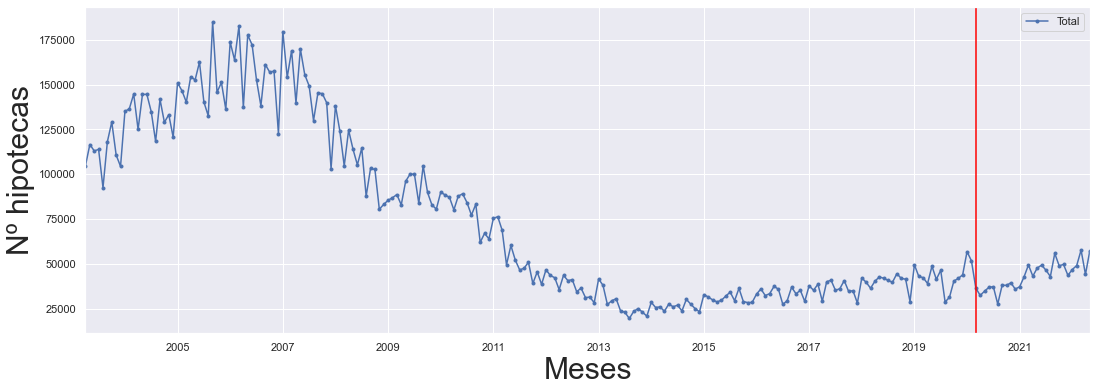

In [63]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_hipotecas.plot(marker='.') 
fig.set_ylabel('Nº hipotecas', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

Se puede apreciar en la gráfica que los números máximos de hipotecas estuvo comprendido entre el año 2005 y 2007, y que a partir del 2008 empezó a bajar el número de ventas de inmuebles. Esto puede ser debido a la crisis financiera de la época. De todos modos, estos datos distorsionan demasiado el análisis que queremos realizar, por lo que seleccionaremos los datos más recientes. Vamos a aplicar un zoom desde el 2014 en adelante:

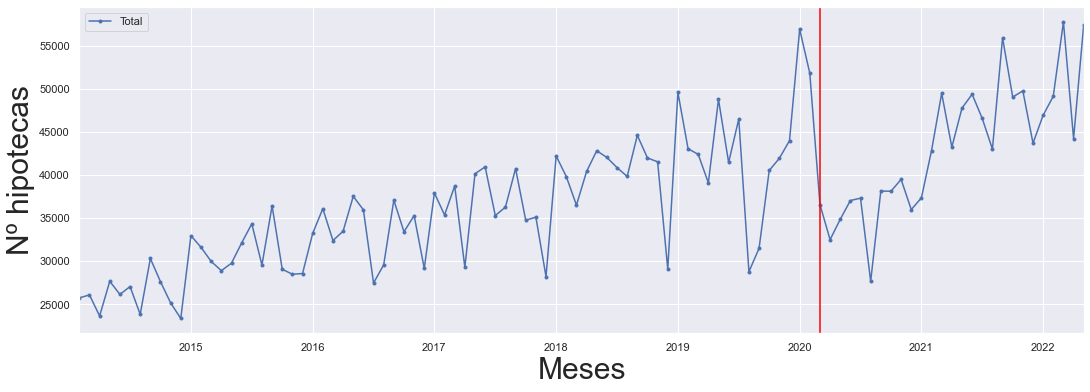

In [64]:
df_hipotecas =  df_hipotecas.iloc[130:]

sns.set(rc={'figure.figsize':(18, 6)})
fig = df_hipotecas.plot(marker='.') 
fig.set_ylabel('Nº hipotecas', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);
# fig.figure.savefig('../pics/df_hipotecas/tendencias.png')

La gráfica presenta una tendencia creciente con una caída en el momento COVID. Debido al confinamiento, no ha habido ventas de inmuebles y se puede reflejar en los meses siguientes a los de febrero del 2020. Sin embargo, a día de hoy la tendencia se está recuperando y está siendo creciente.

A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

### 3.1) Cálculo de la media y de la varianza

In [65]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media=split_and_summarize(df_hipotecas, 'Total', 4, np.mean)
varianza=split_and_summarize(df_hipotecas, 'Total', 4, np.var)

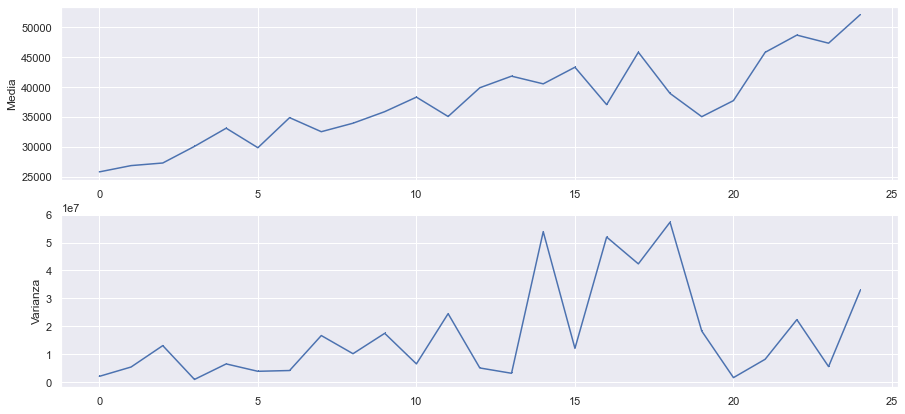

In [66]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()
# fig.figure.savefig('../pics/df_hipotecas/meanvariance.png')

A simple vista la media no es constante a lo largo del tiempo, aunque la varianza no está muy clara para determinar si la serie es estacionaria o no. Para este caso, aplicaremos el Test de Dickey-Fuller aumentado.

### 3.2. Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [67]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_hipotecas)

Results of Dickey-Fuller Test:
Test Statistic                 -0.514991
p-value                         0.889058
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


<u>La serie temporal NO es estacionaria</u>, debido a que el p-value del test Dickey-Fuller (0.88) es mucho mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-0.51) es bastante mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

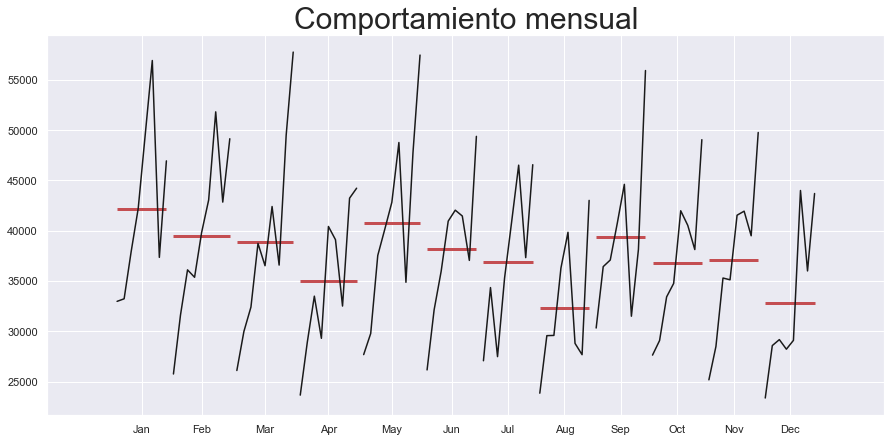

In [68]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_hipotecas['Total'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_hipotecas/monthbehavior.png')

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

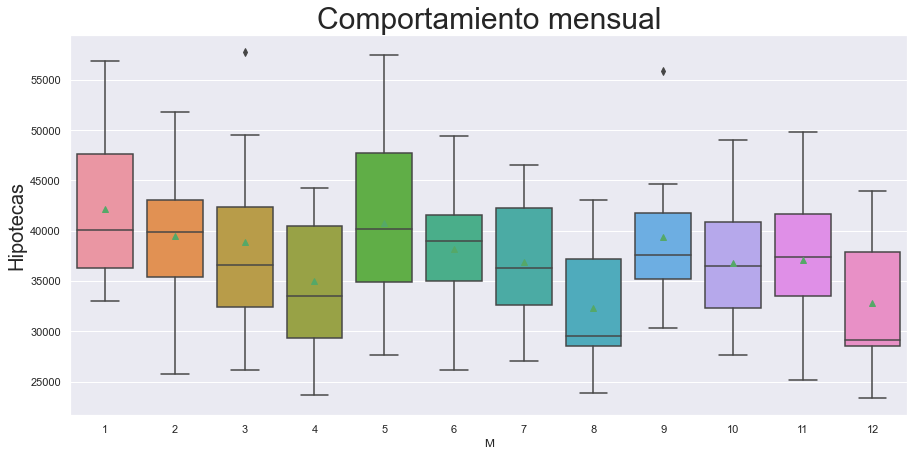

In [69]:
df_hipotecas['M'] = df_hipotecas.index.month
sns.boxplot(data = df_hipotecas, x = 'M', y='Total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Hipotecas', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_hipotecas/boxplotmonth.png')

Se puede apreciar que los meses que más se hipotecan inmuebles son los meses de enero y mayo, por encima de las 45.000 hipotecas. Sin embargo, los meses que menos hipotecas se realizan son abril, agosto y diciembre. 

### 3.4.) Descomposición

Y, por último, vamos a realizar la descomposición de la serie temporal de las hipotecas, que nos indica de un solo vistazo la estacionalidad, la tendencia y los residuos:

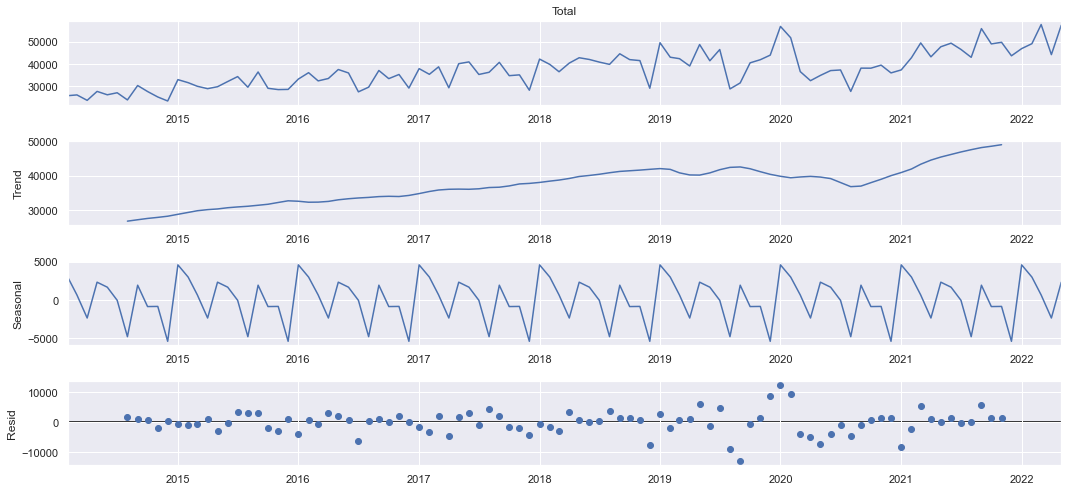

In [70]:
desglose = seasonal_decompose(df_hipotecas['Total'], 
                                   model='additive', 
                                   period=12);
desglose.plot();
# plt.savefig('../pics/df_hipotecas/decompose.png')

Analizando las gráficas, observamos:
- Lo comentado anteriormente en cuanto a tendencia. **El COVID afecta ligeramente a la venta de inmuebles** pero a los meses se vuelve a recuperar la tendencia.
- **Se aprecia estacionalidad**
- Que **no es una serie estacionaria** debido a la irregularidad que hay en la media y en la varianza.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta julio del 2022, hay 29 meses para el test_size.



Cantidad de períodos en Train: 71
Cantidad de períodos en Test: 29


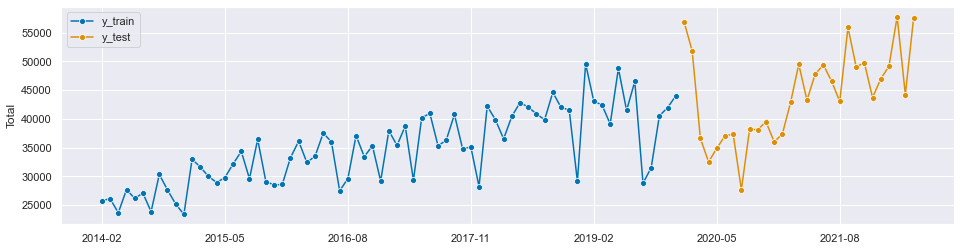

In [71]:
#Train-test
y_train, y_test = temporal_train_test_split(y = df_hipotecas['Total'].astype('float64').to_period('M'), 
                                            test_size=29)
#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [72]:
y_test #observamos los 20 meses testeados

2020-01    56921.0
2020-02    51818.0
2020-03    36588.0
2020-04    32516.0
2020-05    34877.0
2020-06    37054.0
2020-07    37329.0
2020-08    27682.0
2020-09    38155.0
2020-10    38132.0
2020-11    39501.0
2020-12    36007.0
2021-01    37355.0
2021-02    42850.0
2021-03    49490.0
2021-04    43241.0
2021-05    47769.0
2021-06    49382.0
2021-07    46566.0
2021-08    43018.0
2021-09    55925.0
2021-10    49053.0
2021-11    49768.0
2021-12    43702.0
2022-01    46946.0
2022-02    49147.0
2022-03    57760.0
2022-04    44230.0
2022-05    57463.0
Freq: M, Name: Total, dtype: float64

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [73]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
hipotecas_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [74]:
hipotecas_auto_ets.fit(y_train)
hipotecas_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   71
Model:                      ETS(MAdM)   Log Likelihood                -666.566
Date:                Mon, 29 Aug 2022   AIC                           1371.133
Time:                        20:53:34   BIC                           1414.124
Sample:                    02-28-2014   HQIC                          1388.229
                         - 12-31-2019   Scale                            0.007
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0072        nan        nan        nan         nan         nan
smoothing_trend         0.0072        nan        nan        nan         nan         nan
smoothing_seasonal   9.928e-05        nan        nan        nan         nan         nan
damping_trend           0.9800        nan        nan        nan         nan         nan
initial_level        2.643e+04        nan        nan        nan         nan         nan
initial_trend         413.3282        nan        nan        nan         nan         nan
initial_seasonal.0      1.0352        nan        nan        nan         nan         nan
initial_seasonal.1      0.7875        nan        nan        nan         nan         nan
initial_seasonal.2      0.8902        nan        nan        nan         nan         nan
initial_seasonal.3      0.8992        nan        nan        nan         nan         nan
initial_seasonal.4      0.9926        nan        nan        nan         nan         nan
initial_seasonal.5      0.8429        nan        nan        nan         nan         nan
initial_seasonal.6      0.9445        nan        nan        nan         nan         nan
initial_seasonal.7      0.9753        nan        nan        nan         nan         nan
initial_seasonal.8      1.0143        nan        nan        nan         nan         nan
initial_seasonal.9      0.8868        nan        nan        nan         nan         nan
initial_seasonal.10     0.9417        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       15.72   Jarque-Bera (JB):                30.08
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               4.56   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [75]:
#step 5: querying predictions
hipotecas_pred = hipotecas_auto_ets.predict(fh=list(fh))
hipotecas_pred.round()

2020-01    47639.0
2020-02    46222.0
2020-03    43715.0
2020-04    41340.0
2020-05    47480.0
2020-06    45842.0
2020-07    44568.0
2020-08    39925.0
2020-09    47191.0
2020-10    42910.0
2020-11    42633.0
2020-12    37844.0
2021-01    49919.0
2021-02    48380.0
2021-03    45707.0
2021-04    43179.0
2021-05    49540.0
2021-06    47784.0
2021-07    46411.0
2021-08    41536.0
2021-09    49051.0
2021-10    44562.0
2021-11    44235.0
2021-12    39233.0
2022-01    51708.0
2022-02    50074.0
2022-03    47270.0
2022-04    44621.0
2022-05    51157.0
Freq: M, dtype: float64

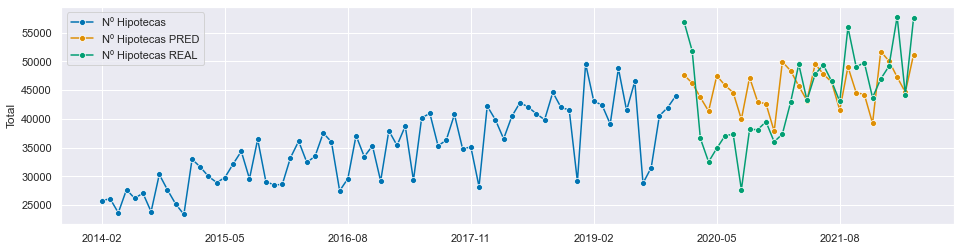

In [76]:
# optional: plotting predictions and past data
plot_series(y_train, hipotecas_pred, y_test,
            labels=["Nº Hipotecas", "Nº Hipotecas PRED", "Nº Hipotecas REAL"])
plt.show()

Se hace un zoom al gráfico:

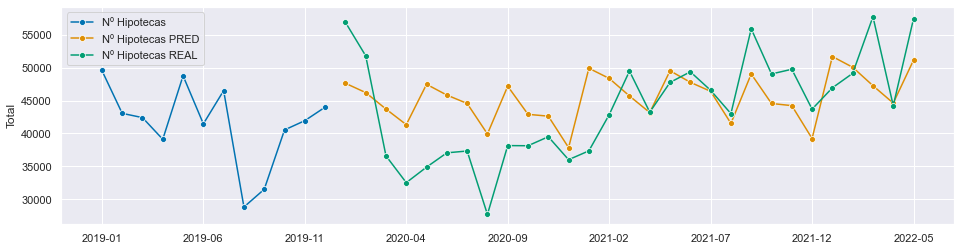

In [77]:
plot_series(y_train["2019":], hipotecas_pred,y_test,
            labels=["Nº Hipotecas", "Nº Hipotecas PRED", "Nº Hipotecas REAL"]);

La predicción por ETS, a simple vista, no predice con mucha certeza el momento del inicio de la pandemia, pero después del verano del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [78]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, hipotecas_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 6706.48


In [79]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, hipotecas_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 13.67%


### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [80]:
transformer = LogTransformer()
log_df_hipotecas= transformer.fit_transform(df_hipotecas['Total'])
log_df_hipotecas.tail()

Periodo
2022-01-01    10.756753
2022-02-01    10.802571
2022-03-01    10.964052
2022-04-01    10.697159
2022-05-01    10.958897
dtype: float64

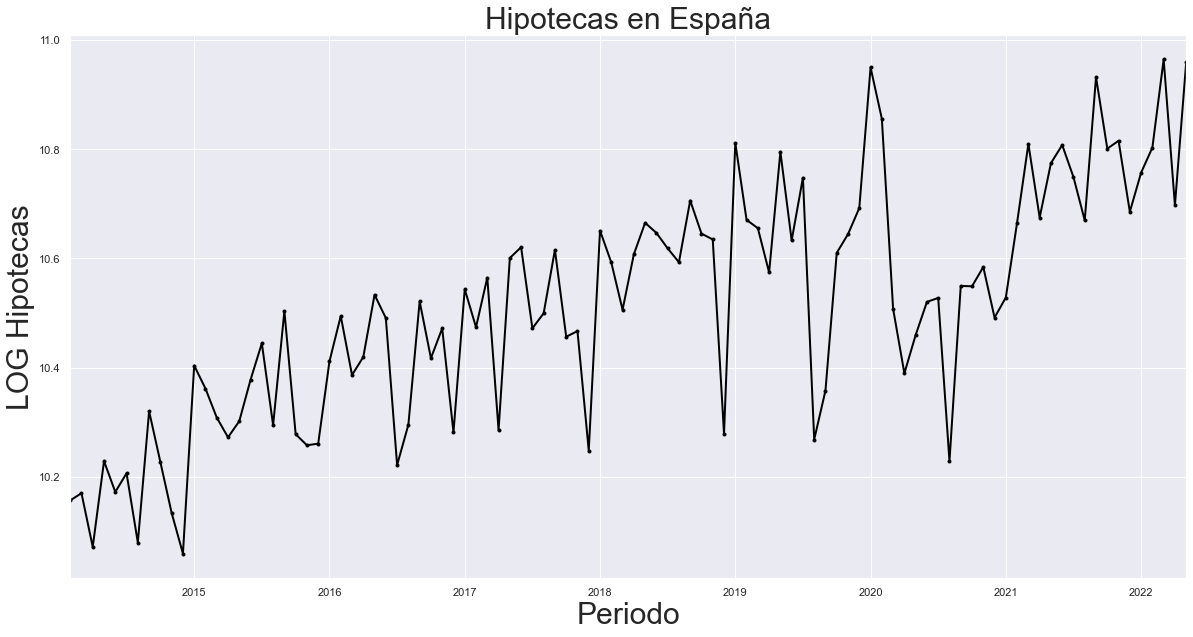

In [81]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_hipotecas.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Hipotecas en España', fontsize = 30) 
fig.set_ylabel('LOG Hipotecas', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

71 29


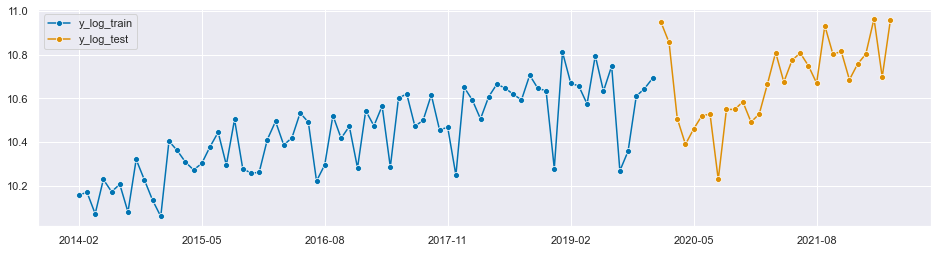

In [82]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_hipotecas.astype('float64').to_period('M').sort_index(),test_size=29)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [83]:
fh = np.arange(1,y_log_test.shape[0]+1)
hipotecas_auto_arima=AutoARIMA(sp=12,suppress_warnings=True)

In [84]:
hipotecas_auto_arima.fit(y_log_train)
hipotecas_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   71
Model:             SARIMAX(4, 1, 1)x(0, 0, 1, 12)   Log Likelihood                  51.426
Date:                            Mon, 29 Aug 2022   AIC                            -86.851
Time:                                    20:53:51   BIC                            -68.863
Sample:                                         0   HQIC                           -79.706
                                             - 71                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0057      0.004      1.476      0.140      -0.002       0.013
ar.L1          0.1188      0.282      0.421      0.674      -0.435       0.672
ar.L2         -0.0036      0.250     -0.014      0.988      -0.494       0.486
ar.L3         -0.1530      0.244     -0.628      0.530      -0.630       0.324
ar.L4          0.2180      0.231      0.943      0.346      -0.235       0.671
ma.L1         -0.9551      0.259     -3.695      0.000      -1.462      -0.448
ma.S.L12       0.3135      0.181      1.732      0.083      -0.041       0.668
sigma2         0.0128      0.002      5.621      0.000       0.008       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.31
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.88   Skew:                            -1.00
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
hipotecas_log_pred = hipotecas_auto_arima.predict(fh)
np.exp(hipotecas_log_pred)

2020-01    43544.226779
2020-02    43342.840371
2020-03    43458.006164
2020-04    44024.734406
2020-05    46091.424449
2020-06    44372.816734
2020-07    45852.526433
2020-08    40356.028557
2020-09    41103.600519
2020-10    44859.394042
2020-11    45432.592545
2020-12    47955.164386
2021-01    46011.918635
2021-02    46832.740782
2021-03    46946.428142
2021-04    48086.929580
2021-05    47932.989374
2021-06    48351.290366
2021-07    48524.383440
2021-08    49099.807282
2021-09    49347.512391
2021-10    49722.763951
2021-11    49998.508290
2021-12    50405.262728
2022-01    50736.679512
2022-02    51104.705981
2022-03    51436.624966
2022-04    51807.244235
2022-05    52162.055781
Freq: M, dtype: float64

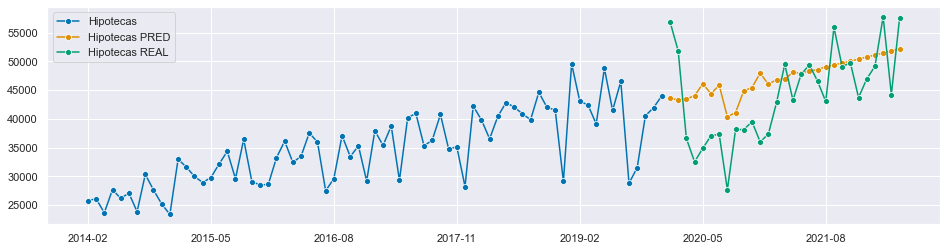

In [86]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(hipotecas_log_pred), np.exp(y_log_test), 
            labels=["Hipotecas", "Hipotecas PRED", "Hipotecas REAL"])
plt.show()

In [87]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(hipotecas_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 7119.64


In [88]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(hipotecas_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 15.03%


#### Una comparativa entre ETS y ARIMA

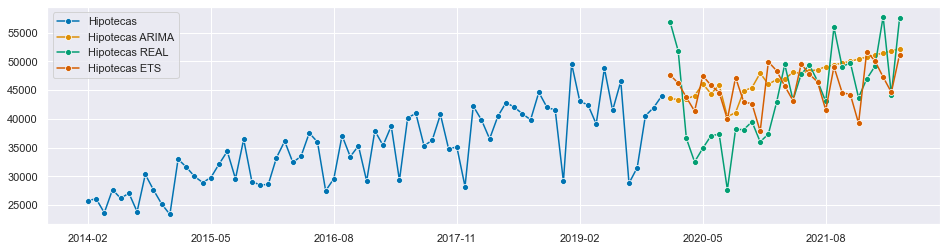

<Figure size 1440x720 with 0 Axes>

In [89]:
plot_series(np.exp(y_log_train["2013":]), np.exp(hipotecas_log_pred), np.exp(y_log_test), hipotecas_pred, 
            labels=["Hipotecas", "Hipotecas ARIMA", "Hipotecas REAL", 'Hipotecas ETS'])
plt.show()
# plt.savefig('../pics/df_hipotecas/etsarima.png')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [90]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 6706.48
El modelo ARIMA genera un RMSE de: 7119.64


In [91]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 13.67%
El modelo ARIMA genera un MAPE de 15.03%


### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [92]:
# Eliminación de la columna 'M' creada anteriormente 
df_hipotecas=df_hipotecas.drop(['M'], axis=1)
df_hipotecas

,Total
Periodo,
2014-02-01,25763.0
2014-03-01,26111.0
2014-04-01,23663.0
2014-05-01,27690.0
2014-06-01,26168.0
...,...
2022-01-01,46946.0
2022-02-01,49147.0
2022-03-01,57760.0


In [93]:
prophet_train = df_hipotecas.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [94]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

71

In [95]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

In [96]:
prophet_y_train.tail()

,ds,y
66,2019-08-31,28805.0
67,2019-09-30,31506.0
68,2019-10-31,40538.0
69,2019-11-30,41947.0
70,2019-12-31,44001.0


In [97]:
prophet_y_test.head()

,ds,y
0,2020-01-31,56921.0
1,2020-02-29,51818.0
2,2020-03-31,36588.0
3,2020-04-30,32516.0
4,2020-05-31,34877.0


In [98]:
m = Prophet()
m.fit(prophet_y_train)

20:54:13 - cmdstanpy - INFO - Chain [1] start processing
20:54:13 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

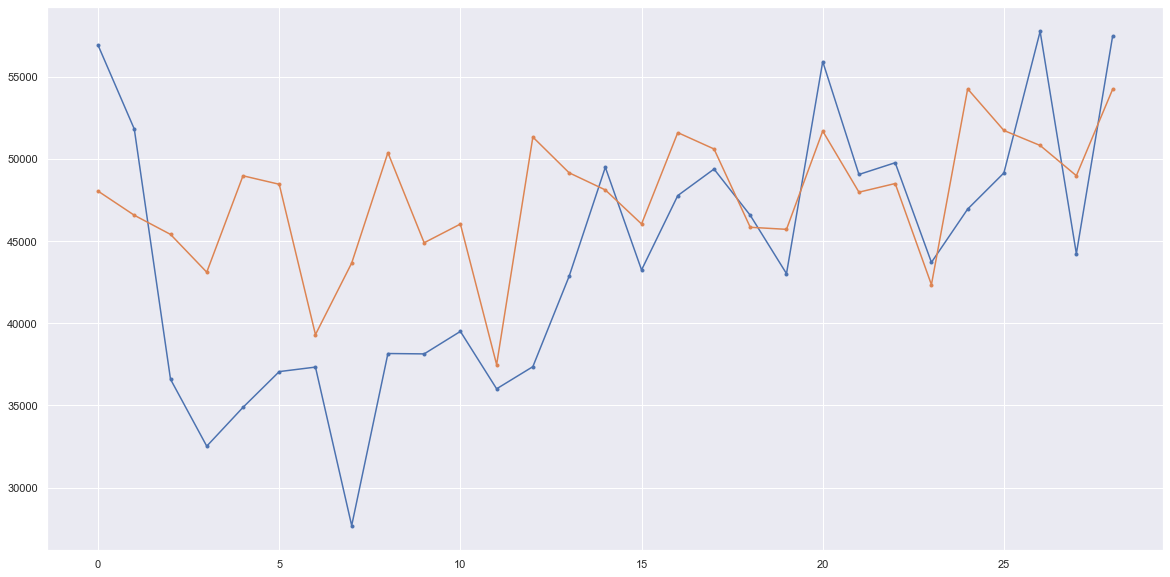

In [100]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[71:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_hipotecas/prophet.png')

In [52]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[71:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 14.87%


In [54]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[71:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 7327.29


In [55]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
95,2022-01-31,54263.0,50514.0,57758.0
96,2022-02-28,51731.0,48295.0,55400.0
97,2022-03-31,50819.0,47210.0,54291.0
98,2022-04-30,48978.0,45556.0,52423.0
99,2022-05-31,54233.0,50716.0,57998.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [56]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 6706.48
El modelo ARIMA genera un RMSE de: 7119.64
El modelo Prophet genera un RMSE de: 7327.29


2) MAPE (Error porcentual)

In [57]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 13.67%
El modelo ARIMA genera un MAPE de 15.03%
El modelo Prophet genera un MAPE de 14.87%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ETS**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del desempleo intervenido hasta finales de año, es decir, hasta diciembre del 2022. 

In [58]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, 6)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
autoets_predict = AutoETS(auto=True, sp=12, n_jobs=-1)
y = df_hipotecas.astype('float64').to_period('M')
autoets_predict.fit(y)

AutoETS(auto=True, n_jobs=-1, sp=12)

In [59]:
print(autoets_predict.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  100
Model:                       ETS(MAM)   Log Likelihood                -963.794
Date:                Thu, 25 Aug 2022   AIC                           1963.587
Time:                        13:20:18   BIC                           2010.480
Sample:                    02-28-2014   HQIC                          1982.566
                         - 05-31-2022   Scale                            0.010
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3529        nan        nan        nan         nan         nan
smoothing_trend      3.529e-05        nan        nan        nan         nan         nan
smoothing_season

In [60]:
# Predicción del desempleo para los próximos 6 meses:
hipotecasnew_pred = autoets_predict.predict(fh=list(fh))
hipotecasnew_pred.round()

,Total
2022-06,53619.0
2022-07,52147.0
2022-08,46167.0
2022-09,56083.0
2022-10,51866.0


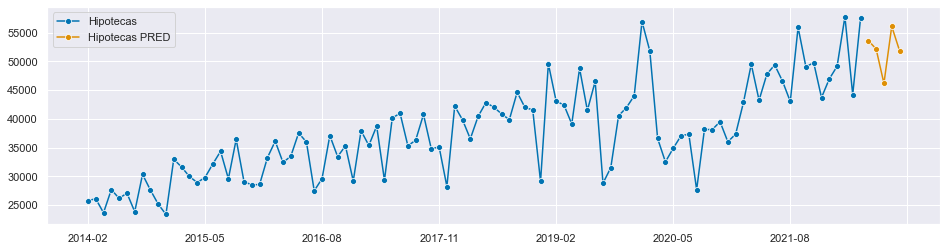

In [61]:
# Representamos gráficamente:
plot_series(y, hipotecasnew_pred, labels=["Hipotecas", "Hipotecas PRED"])
# plt.savefig('../pics/df_hipotecas/predict2022.png')